# <font size="8" color="salmon"><center>***Ambulance Dispatch Problem***</center></font>

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

In [89]:
mpl.rcParams['text.usetex'] = True
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], "size": 14})
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.rcParams["axes.linewidth"] = 0.5

# <font size="6" color="plum">**Ambulance Dispatch Environment**</font>

In [2]:
from ambulance_dispatch import *

In [3]:
# Imput: Coordenadas mapa de Bogota, número de ambulancias disponibles y número de puntos de despacho
env = AmbulanceDispatch(north=4.659802, south=4.576742, east=-74.064810, west=-74.171380, n_ambulances=3, n_dispatch=6)
# Se demora casi 1 minuto en cargar

c:\Users\valen\anaconda3\envs\anaconda_py311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best bandwidth: 0.09824524524524525


In [4]:
# Todas las posibles acciones disponibles (posibles configuraciones) -> 220 posibles acciones
env.allowed_actions
# Por ejemplo: Acción 0: (0,0,0) -> Ambulancia 1 está en lugar de despacho 0, Ambulancia 2 en 0, Ambulancia 3 en 0.
#              Acción 24: (0,2,7) -> Ambulancia 1 en lugar de despacho 0, Ambulancia 2 en lugar 2, Ambulancia 3 en lugar de despacho 7

{0: (0, 0, 0),
 1: (0, 0, 1),
 2: (0, 0, 2),
 3: (0, 0, 3),
 4: (0, 0, 4),
 5: (0, 0, 5),
 6: (0, 1, 1),
 7: (0, 1, 2),
 8: (0, 1, 3),
 9: (0, 1, 4),
 10: (0, 1, 5),
 11: (0, 2, 2),
 12: (0, 2, 3),
 13: (0, 2, 4),
 14: (0, 2, 5),
 15: (0, 3, 3),
 16: (0, 3, 4),
 17: (0, 3, 5),
 18: (0, 4, 4),
 19: (0, 4, 5),
 20: (0, 5, 5),
 21: (1, 1, 1),
 22: (1, 1, 2),
 23: (1, 1, 3),
 24: (1, 1, 4),
 25: (1, 1, 5),
 26: (1, 2, 2),
 27: (1, 2, 3),
 28: (1, 2, 4),
 29: (1, 2, 5),
 30: (1, 3, 3),
 31: (1, 3, 4),
 32: (1, 3, 5),
 33: (1, 4, 4),
 34: (1, 4, 5),
 35: (1, 5, 5),
 36: (2, 2, 2),
 37: (2, 2, 3),
 38: (2, 2, 4),
 39: (2, 2, 5),
 40: (2, 3, 3),
 41: (2, 3, 4),
 42: (2, 3, 5),
 43: (2, 4, 4),
 44: (2, 4, 5),
 45: (2, 5, 5),
 46: (3, 3, 3),
 47: (3, 3, 4),
 48: (3, 3, 5),
 49: (3, 4, 4),
 50: (3, 4, 5),
 51: (3, 5, 5),
 52: (4, 4, 4),
 53: (4, 4, 5),
 54: (4, 5, 5),
 55: (5, 5, 5)}

In [5]:
# Función de recompensas -> Tiempo promedio de respuesta a accidentes -> en minutos 
# Tiempo de respuesta: Tiempo de llegada al accidente - tiempo cuando comienza el accidente
# Cada episodio (1 día) cuenta con 18 accidentes a atender -> se demora como 0.3 segundos por cada episodio
# Por ejemplo, tomemos una acción
action = env.allowed_actions[55]
print(env.episode_reward(action)) # Su recompensa es:-5.285462962962966
# La recompensa es aleatoria porque los accidentes suceden de manera aleatoria
print(env.episode_reward(action))

-10.540480684561787
-10.123611111111101


## <font size="5" color="GoldenRod">**Gradient Bandit Algorithm (GBA)**</font>

In [6]:
k = len(env.allowed_actions.keys())
tasks = 5
steps = 50

In [7]:
k

56

In [8]:
def gba(comb): # Dada una combinación de parametros
    steps = comb[0] 
    alpha = comb[1]
    # Las preferencias se inician en 0, como en el libro
    v0 = k*[-15.0]
    # Diccionario donde se guardará la acción elegida y su recompensa en el paso t
    gba = {}
    # Inicializar valores para las preferencias y para el retorno promedio (baseline)
    H = np.array(v0)
    Q = 0
    # Se ejecuta el algoritmo en cada paso
    for t in range(steps):
        prob =  np.exp(H)/(np.exp(H).sum()) # Obtener probabilidades con soft-max
        # Escoger una acción aleatoria dadas las anteriores probabilidades
        a_star = np.random.choice(range(k),p=prob)
        R = env.episode_reward(env.allowed_actions[a_star]) # Obtener la recompensa al elegir la acción anterior
        # Guardar la acción escogida con la recompensa en el diccionario
        gba[t] = [a_star,R]
        # Actualizar recompensa promedio hasta t e incluyendo la recompensa de la acción en t
        Q = Q + (1/(t+1))*(R - Q) 
        # Actualizar para cada acción su preferencia. 
        H[a_star] = H[a_star] + alpha*(R-Q)*(1-prob[a_star])
        H[:a_star] = H[:a_star] - alpha*(R-Q)*prob[:a_star] 
        H[a_star+1:] = H[a_star+1:] - alpha*(R-Q)*prob[a_star+1:] 
    return gba

In [9]:
# Función que implementa el algoritmo dada una combinación de parametros, 2000 veces (tasks)
# Y obtiene el porcentaje de acciones elegidas en cada paso junto con la recompensa promedio
def result_comb(comb):
    np.random.seed(10)
    # Para cada task correr el algoritmo de gba usando 1000 pasos y para cada task guardar resultados
    # De las acciones y recompensas en dos numpy arrays separados
    actions = np.array([[0.0]*steps]*tasks) 
    rewards = np.array([[0.0]*steps]*tasks)
    for z in range(0,tasks):
        it = gba(comb)
        actions[z:] = [s for (s,k) in it.values()]
        rewards[z:] = [k for (s,k) in it.values()]
    actions = pd.DataFrame(np.matrix([np.where(actions==a, 1, 0).sum(axis=0)*100/tasks for a in range(0,k)])).T
    rewards = pd.DataFrame(rewards.mean(axis=0))
    return {"actions":actions, "rewards":rewards}

In [10]:
tasks = 10 # 50->1000
steps = 1500 #2000
alpha = {"0":1/32,"1":1/16, "2":1/8, "3":1/4, "4":1/2}
df_graph = {} # Donde guardaremos los resultados para cada combinación de parámetros
# Crear todas las combinaciones posibles de parametros
comb_dict = {} 
h = 0
for j in alpha.keys():
    comb_dict[h] = [j,[steps,alpha[j]]] 
    h += 1

In [11]:
np.random.seed(10)
for h in tqdm(range(0, len(comb_dict.keys()))):
    df_graph[comb_dict[h][0]] = result_comb(comb_dict[h][1])

100%|██████████| 5/5 [50:53<00:00, 610.74s/it]


In [40]:
mean_rew = {alpha[j]:df_graph[j]["rewards"].mean()[0] for j in alpha.keys()}
mean_rew = pd.DataFrame.from_dict(mean_rew, orient="index")
print(f"La recompensa promedio para cada valor de alpha es: {mean_rew}")

La recompensa promedio para cada valor de alpha es:                 0
0.03125 -7.112126
0.06250 -6.434626
0.12500 -6.504407
0.25000 -6.273232
0.50000 -6.383037


In [45]:
# Para la legenda de las graficas
labels_dict = {}
for j in alpha.keys():
    labels_dict[j] = f"Alpha: {alpha[j].as_integer_ratio()}" 

Text(0.5, 0, 'Steps')

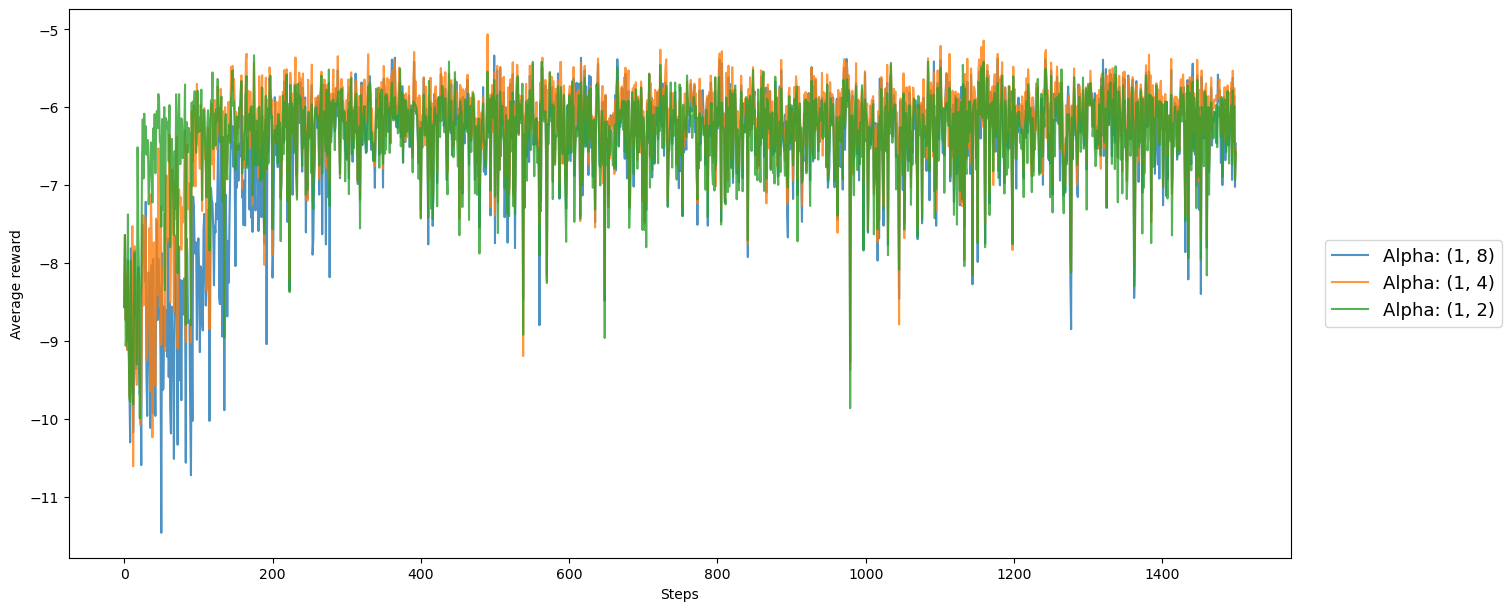

In [52]:
fig, axes = plt.subplots(1,1,figsize=(15,6), constrained_layout=True)
for j in ["2","3","4"]:
    plt.plot(df_graph[j]["rewards"],label=labels_dict[j],alpha=0.8)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left",fontsize=13)
plt.ylabel("Average reward")
plt.xlabel("Steps")

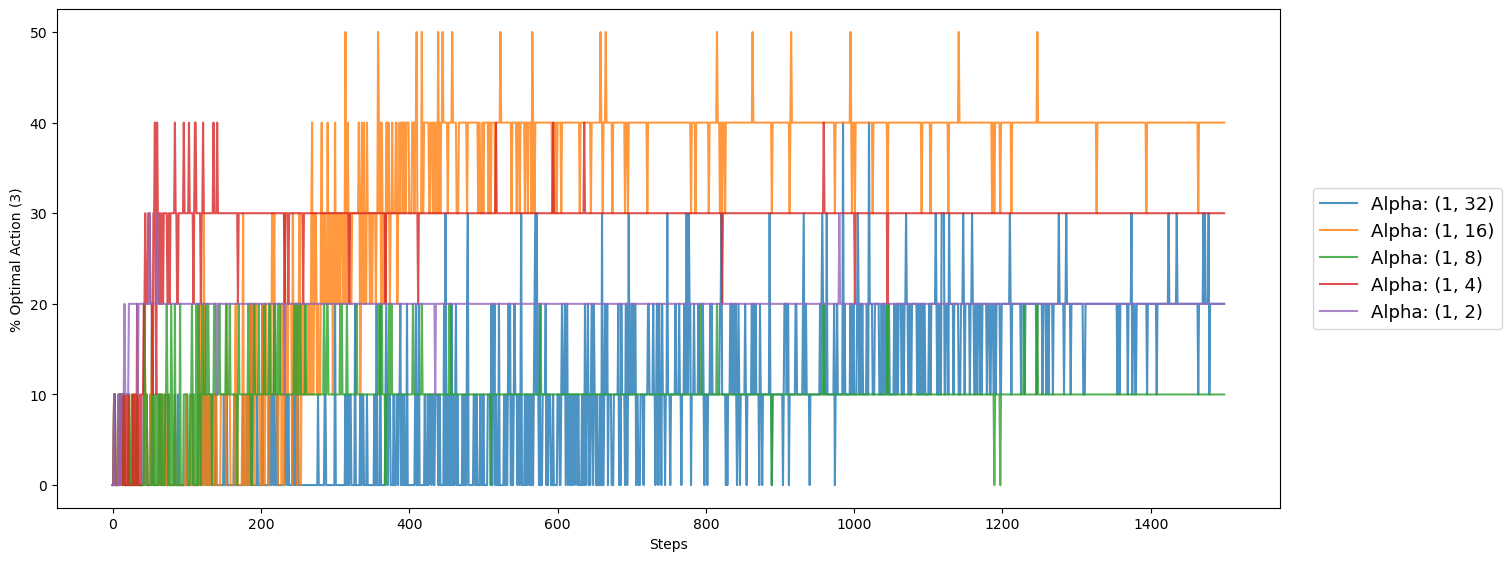

In [54]:
fig, axes = plt.subplots(1,1,figsize=(15,5.5), constrained_layout=True)
for j in alpha.keys():
    plt.plot(df_graph[j]["actions"][19],label=labels_dict[j],alpha=0.8)
plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left",fontsize=13)
plt.ylabel("% Optimal Action (3)")
plt.xlabel("Steps")
plt.show()

In [53]:
np.argmax(df_graph["3"]["actions"].sum(axis=0))

19

In [55]:
tasks = 300 # 50->1000
steps = 2000 #2000
opt_alpha = 1/4 
alpha = {"3":1/4}
df_graph = {} # Donde guardaremos los resultados para cada combinación de parámetros
# Crear todas las combinaciones posibles de parametros
comb_dict = {} 
h = 0
for j in alpha.keys():
    comb_dict[h] = [j,[steps,alpha[j]]] 
    h += 1

In [56]:
np.random.seed(10)
for h in tqdm(range(0, len(comb_dict.keys()))):
    df_graph[comb_dict[h][0]] = result_comb(comb_dict[h][1])

100%|██████████| 1/1 [7:09:56<00:00, 25796.25s/it]


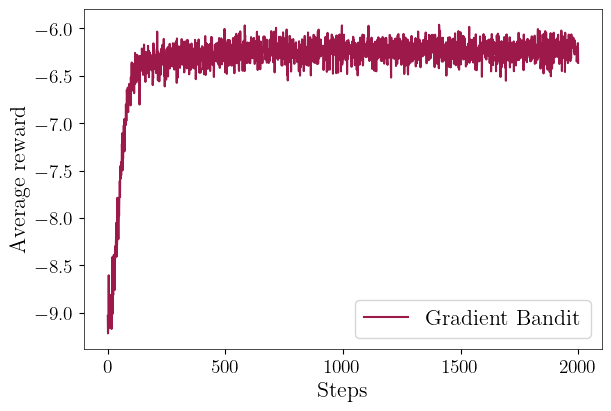

In [151]:
fig, axes = plt.subplots(1,1,figsize=(6,4), constrained_layout=True)
for j in ["3"]:
    plt.plot(df_graph[j]["rewards"],label="Gradient Bandit",alpha=1, color="#9D1949")
plt.legend(loc="lower right", fontsize=16)
plt.ylabel("Average reward", fontsize=16)
plt.xlabel("Steps", fontsize=16)
#plt.savefig("gba_rewards.png",dpi=200,bbox_inches='tight')

In [212]:
# Avg reward through all steps
print(df_graph["3"]["rewards"].mean())
# Avg reward through the last 500 steps
print(df_graph["3"]["rewards"][-500:].mean())

0   -6.331898
dtype: float64
0   -6.228846
dtype: float64


In [75]:
#df_graph["3"]["actions"].to_excel("gba_actions.xlsx")
#df_graph["3"]["rewards"].to_excel("gba_rewards.xlsx")

In [63]:
np.sort(df_graph["3"]["actions"].sum(axis=0))

array([   80.        ,    85.33333333,    86.66666667,    94.        ,
          95.        ,    97.        ,    98.        ,    98.33333333,
          99.        ,   100.66666667,   101.33333333,   102.33333333,
         102.66666667,   103.66666667,   104.66666667,   109.66666667,
         111.66666667,   111.66666667,   112.        ,   113.33333333,
         113.66666667,   114.66666667,   116.33333333,   120.33333333,
         121.66666667,   123.33333333,   123.66666667,   124.66666667,
         126.33333333,   132.66666667,   134.33333333,   135.        ,
         136.        ,   139.33333333,   139.66666667,   148.33333333,
         149.33333333,   149.33333333,   151.33333333,   155.33333333,
         197.66666667,   243.33333333,   243.66666667,   785.66666667,
        2949.33333333,  4548.33333333,  5046.66666667,  5291.        ,
        5941.33333333,  6398.33333333,  7378.66666667, 10716.66666667,
       21468.66666667, 25604.33333333, 42942.        , 55582.        ])

In [64]:
df_graph["3"]["actions"].sum(axis=0)

0        85.333333
1       243.666667
2        97.000000
3       102.666667
4       113.333333
5       155.333333
6     21468.666667
7      4548.333333
8      5291.000000
9      5046.666667
10    55582.000000
11      102.333333
12      109.666667
13      116.333333
14     7378.666667
15      112.000000
16      151.333333
17     6398.333333
18      124.666667
19    42942.000000
20    25604.333333
21      121.666667
22      785.666667
23      114.666667
24      123.333333
25      149.333333
26      126.333333
27      136.000000
28      149.333333
29    10716.666667
30      111.666667
31      123.666667
32      135.000000
33      120.333333
34     2949.333333
35      132.666667
36       86.666667
37      100.666667
38       99.000000
39      148.333333
40      103.666667
41       94.000000
42      139.666667
43      111.666667
44     5941.333333
45      197.666667
46       80.000000
47       98.333333
48       95.000000
49      113.666667
50      134.333333
51      101.333333
52       98.

In [100]:
str(env.allowed_actions[10])

'(0, 1, 5)'

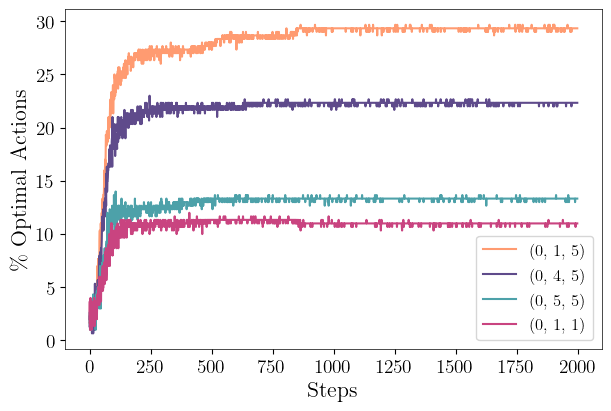

In [214]:
colors = [ '#FF9B71',"#5F4B8B",'#4DA1A9', "#C94480",'#A30047','#1D1E18' ,"#ABB557", '#2B3A67',"#6E1E66", "#577399", "#8B5A2B", "#20B2AA", "#FF5733"]
fig, axes = plt.subplots(1,1,figsize=(6,4), constrained_layout=True)
h = 0
for j in ["3"]:
    for x in [10,19,20,6]:
        plt.plot(df_graph[j]["actions"][x],label=f"{env.allowed_actions[x]}",alpha=1, c=colors[h])
        h +=1

plt.ylabel("\% Optimal Actions", fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.legend( loc="lower right",fontsize=12)
#plt.savefig("gba_action.png",dpi=200,bbox_inches='tight')

In [158]:
disp = np.array(list(env.coord_dispatch.values()))

In [179]:
env.coord_dispatch

{0: [4.6280581, -74.1619045],
 1: [4.5973685, -74.1151927],
 2: [4.6361238, -74.1282179],
 3: [4.6349619, -74.0795545],
 4: [4.595586, -74.1507675],
 5: [4.5943314, -74.0838923]}

In [167]:
disp

array([[  4.6280581, -74.1619045],
       [  4.5973685, -74.1151927],
       [  4.6361238, -74.1282179],
       [  4.6349619, -74.0795545],
       [  4.595586 , -74.1507675],
       [  4.5943314, -74.0838923]])

In [216]:
env.allowed_actions[10]

(0, 1, 5)

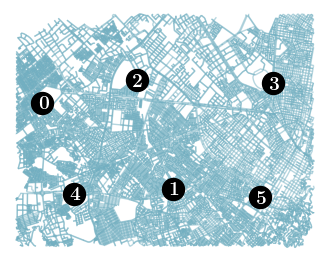

In [202]:
fig, ax =ox.plot_graph(env.G, node_size=0, show=False,bgcolor='w', edge_color="#71AFC1", edge_alpha=0.5, figsize=(4,4))
for i in range(env.n_dispatch):
    ax.scatter(disp[i,1],disp[i,0],color="black", s=250, alpha=1)
    ax.annotate(f"$\mathbf{i}$", xy=(disp[i,1]-0.0012, disp[i,0]-0.002), color="white",fontsize=14, weight=1000)
#fig.savefig("dispatch_locations.png",dpi=200,bbox_inches='tight')

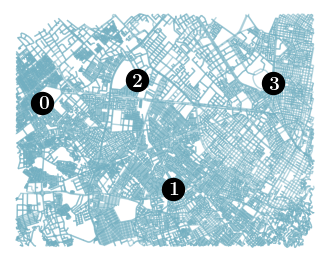

In [349]:
fig, ax =ox.plot_graph(env.G, node_size=0, show=False,bgcolor='w', edge_color="#71AFC1", edge_alpha=0.5, figsize=(4,4))
for i in range(4):
    ax.scatter(disp[i,1],disp[i,0],color="black", s=250, alpha=1)
    ax.annotate(f"$\mathbf{i}$", xy=(disp[i,1]-0.0012, disp[i,0]-0.002), color="white",fontsize=14, weight=1000)
#fig.savefig("optimal_dispatch.png",dpi=200,bbox_inches='tight')

In [351]:
env.accidents

array([    1,  5526, 15492, 13166, 13541, 12470,   776, 14579,  1963,
       13918,  7928, 15719,  2016, 17515,  1883,   317,  1978,  9128])

In [350]:

# Open the saved image
img = Image.open("optimal_dispatch.png")
img = img.convert("P", palette=Image.ADAPTIVE, colors=256)
img.save("optimal_dispatch.png", format='PNG', optimize=True, quality=100)

## <font size="5" color="GoldenRod">**Upper Confidence Bound (UCB)**</font>

In [218]:
ucb_rw = pd.read_csv("rewards_act_UCB.csv")

In [229]:
ucb_act = pd.read_csv("opt_act_UCB.csv", index_col=0)

In [226]:
# Avg reward through all steps
print(ucb_rw["Reward"].mean())
# Avg reward through the last 500 steps
print(ucb_rw["Reward"][-500:].mean())

-5.979655022854184
-5.878195149774292


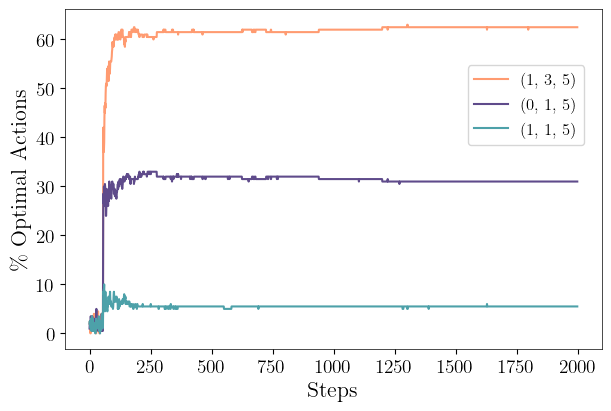

In [261]:
colors = [ '#FF9B71',"#5F4B8B",'#4DA1A9', "#C94480",'#A30047','#1D1E18' ,"#ABB557", '#2B3A67',"#6E1E66", "#577399", "#8B5A2B", "#20B2AA", "#FF5733"]
fig, axes = plt.subplots(1,1,figsize=(6,4), constrained_layout=True)
h = 0
for j in ["3"]:
    for x in [32,10,25]:
        plt.plot((ucb_act*100)[str(x)],label=f"{env.allowed_actions[x]}",alpha=1, c=colors[h])
        h +=1

plt.ylabel("\% Optimal Actions", fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.legend( loc=(0.75,0.6),fontsize=12)
#plt.savefig("ucb_action.png",dpi=200,bbox_inches='tight')

Text(0.5, 0, 'Steps')

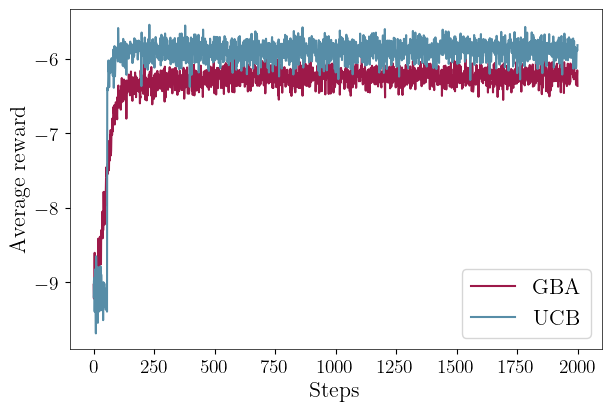

In [225]:
fig, axes = plt.subplots(1,1,figsize=(6,4), constrained_layout=True)
for j in ["3"]:
    plt.plot(df_graph[j]["rewards"],label="GBA",alpha=1, color="#9D1949")
plt.plot(ucb_rw["Reward"],label="UCB",alpha=1, color="#578DA7")
plt.legend(loc="lower right", fontsize=16)
plt.ylabel("Average reward", fontsize=16)
plt.xlabel("Steps", fontsize=16)
#plt.savefig("rewards.png",dpi=200,bbox_inches='tight')

## <font size="5" color="GoldenRod">**Epsilon Greedy**</font>

In [302]:
eps_rw = pd.read_csv("Rescompensas_epsilon_greedy_e_optimo")

In [308]:
eps_act = pd.read_csv("Acciones_optimas_epsilon_greedy")

In [307]:
# Avg reward through all steps
print(eps_rw["0"].mean())
# Avg reward through the last 500 steps
print(eps_rw["0"][-500:].mean())

-5.822036303151566
-5.71210833794818


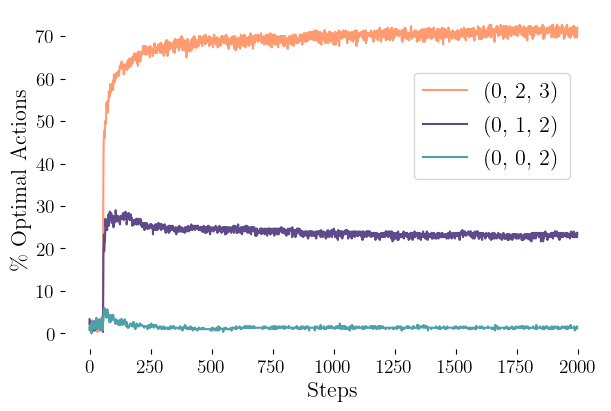

In [346]:
colors = [ '#FF9B71',"#5F4B8B",'#4DA1A9', "#C94480",'#A30047','#1D1E18' ,"#ABB557", '#2B3A67',"#6E1E66", "#577399", "#8B5A2B", "#20B2AA", "#FF5733"]
fig, axes = plt.subplots(1,1,figsize=(6,4), constrained_layout=True)
h = 0
for j in ["3"]:
    for x in [12, 7, 2]:
        plt.plot(eps_act[str(x)],label=f"{env.allowed_actions[x]}",alpha=1, c=colors[h])
        h +=1

plt.ylabel("\% Optimal Actions", fontsize=16)
plt.xlabel("Steps", fontsize=16)
plt.legend( loc=(0.65,0.5),fontsize=16)
axes.spines[['top', "right", "left", "bottom"]].set_visible(False)
plt.savefig("eps_action.png",dpi=200,bbox_inches='tight')

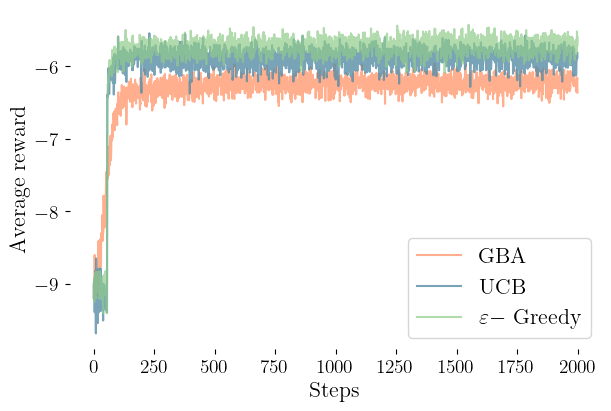

In [340]:
fig, axes = plt.subplots(1,1,figsize=(6,4), constrained_layout=True)
for j in ["3"]:
    plt.plot(df_graph[j]["rewards"],label="GBA",alpha=0.8, color="#FF9B71")
plt.plot(ucb_rw["Reward"],label="UCB",alpha=0.8, color="#578DA7")
plt.plot(eps_rw["0"],label=r"$\varepsilon -$ Greedy",alpha=0.7, color="#90CB8B")
plt.legend(loc="lower right", fontsize=16)
plt.ylabel("Average reward", fontsize=16)
plt.xlabel("Steps", fontsize=16)
axes.spines[['top', "right", "left", "bottom"]].set_visible(False)
plt.savefig("rewards.png",dpi=200,bbox_inches='tight')

In [264]:
import random 

In [284]:

k = len(list(env.allowed_actions))
# Dado el análisis anterior es posible que la acción 3 sea la óptima

# Función que determina la acción greedy -> la acción que maximiza la recompensa
# Promedio hasta el paso t
def greedy(Q):
    greedy_actions = []
    max_Q = -1e8
    for a in range(k):
        if Q[a] > max_Q: greedy_actions = [a]; max_Q = Q[a]
        elif Q[a] == max_Q: greedy_actions.append(a)
    return random.choice(greedy_actions)

def e_greedy(epsilon,optimistic,runs,steps):

    # cum_R: dictionary that keeps track of the mean reward for each time step, across all runs
    cum_R = {i:0 for i in range(steps)}
    # opt_act: dictionary that keeps track of the % of runs that the optimal action was selected for each time step
    opt_act = {a: {i:0 for i in range(steps)} for a in range(k)}
    for i in range(runs):
        # Action value. It's rewritten at each step for computational efficiency
        Q = {a:optimistic for a in range(k)}
        # Number of times that action a has been selected
        N = {a:0 for a in range(k)}
        for j in range(steps):
            if random.random() <= 1-epsilon:
                A = greedy(Q)
            else: 
                A = random.choice(range(k))
            R = env.episode_reward(env.allowed_actions[A])
            # Average cumulative reward up until current time-step j, across runs
            cum_R[j] = (cum_R[j]*(i) + R)/(i+1)
            # % of runs that have chosen the optimal action on time-step j
            for a in range(k):
                if A == a: opt_act[a][j] = (opt_act[a][j]*(i) + 1)/(i+1)
                else: opt_act[a][j] = (opt_act[a][j]*i)/(i+1)
            # Updates times that current action has been selected
            N[A] += 1
            # Estimated value updated
            Q[A] += (1/N[A])*(R-Q[A])
    print(f"Done {epsilon,optimistic}")
    return cum_R, opt_act

In [290]:
cum_R, opt_act = e_greedy(0.02,0,6,1500)

Done (0.02, 0)


In [300]:
pd.DataFrame.from_dict(cum_R, orient="index")[0].mean()

-5.668086659149882

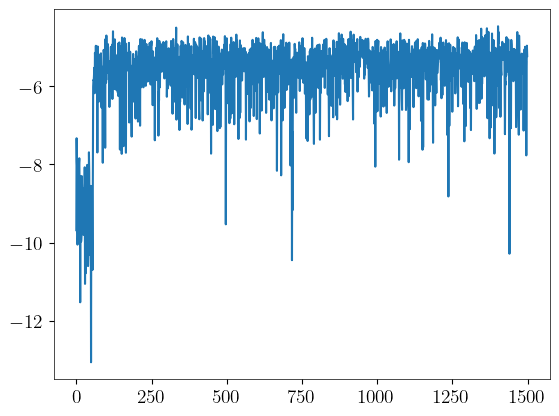

In [291]:
plt.plot(pd.DataFrame.from_dict(cum_R, orient="index")[0])

In [279]:
(pd.DataFrame.from_dict(opt_act)*100)

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
